[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ZuchniakK/CryptoDataProcessing/blob/main/1_binance_download.ipynb)

### This notebook shows how to get trades data from the Binance exchange and how to convert trades into OHLC data for any time interval. Statistics like volume weighted average price for a given period, volume, asset volume, buyer taker ratio are calculated. Additionally, technical analysis indicators are computed.

In [1]:
import io
import zipfile
from concurrent.futures import ALL_COMPLETED, ThreadPoolExecutor, wait
from datetime import date, timedelta
from functools import partial
from os import makedirs
from os.path import join
from time import monotonic

import matplotlib.pyplot as plt
import missingno as msno
import mplfinance as mpf
import numpy as np
import pandas as pd
import pandas_ta as ta
import requests
import talib
from ta import add_all_ta_features
from ta.utils import dropna
from tqdm.notebook import tqdm, trange

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [8, 8]

In [3]:
# Find more Binance data on https://www.binance.com/en/landing/data
BASE_BINANCE_DATA_URL = "https://data.binance.vision"
# specify the folder where you want to save the downloaded and processed data
DATA_DIR = "data"

In [4]:
# Download a ZIP file and extract its contents in memory yields (filename, file-like object) pairs
def download_extract_zip(url):
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
        for zipinfo in thezip.infolist():
            with thezip.open(zipinfo) as thefile:
                yield zipinfo.filename, thefile

In [5]:
# Download trades from Binance for particular spot pair and date
def get_trades(symbol, year, month, day):
    url = f"{BASE_BINANCE_DATA_URL}/data/spot/daily/trades/{symbol.upper()}/{symbol.upper()}-trades-{year}-{month}-{day}.zip"
    file_gen = download_extract_zip(url)
    df = pd.read_csv(
        next(file_gen)[1],
        usecols=[0, 1, 2, 3, 4, 5],
        names=["tradeId", "price", "qty", "quoteQty", "timestamp", "isBuyerMaker"],
    )
    # we add one line at the beginning and end of the dataframe, with the first possible and last possible timestamp
    # of a given day, with the copied values from the first and last trading event. This way we avoid missing time slots
    ms_in_day = 1000 * 3600 * 24
    first_day_timestamp = df["timestamp"][0] - df["timestamp"][0] % ms_in_day
    last_day_timestamp = first_day_timestamp + ms_in_day - 1
    first_indices = df.iloc[0].values
    first_indices[2] = 0
    first_indices[3] = 0
    first_indices[4] = first_day_timestamp
    last_indices = df.iloc[-1].values
    last_indices[2] = 0
    last_indices[3] = 0
    last_indices[4] = last_day_timestamp
    df = pd.concat(
        [
            pd.DataFrame(
                [first_indices],
                columns=[
                    "tradeId",
                    "price",
                    "qty",
                    "quoteQty",
                    "timestamp",
                    "isBuyerMaker",
                ],
            ),
            df,
            pd.DataFrame(
                [last_indices],
                columns=[
                    "tradeId",
                    "price",
                    "qty",
                    "quoteQty",
                    "timestamp",
                    "isBuyerMaker",
                ],
            ),
        ],
        ignore_index=True,
    )

    # Converting the index as date
    df.index = pd.to_datetime(df.timestamp, unit="ms")
    return df

In [6]:
# Download aggregated trades from Binance for particular spot pair and date
def get_aggTrades(symbol, year, month, day):
    url = f"{BASE_BINANCE_DATA_URL}/data/spot/daily/aggTrades/{symbol.upper()}/{symbol.upper()}-aggTrades-{year}-{month}-{day}.zip"
    file_gen = download_extract_zip(url)
    df = pd.read_csv(
        next(file_gen)[1],
        usecols=[0, 1, 2, 3, 4, 5, 6],
        index_col=5,
        names=[
            "aggTradeId",
            "price",
            "quantity",
            "firstTradeId",
            "lastTradeId",
            "timestamp",
            "isBuyerMaker",
        ],
    )

    # Converting the index as date
    df.index = pd.to_datetime(df.index, unit="ms")
    return df

In [7]:
# Download klines from Binance for particular spot pair and date
def get_klines(symbol, interval, year, month, day):
    url = f"{BASE_BINANCE_DATA_URL}/data/spot/daily/klines/{symbol.upper()}/{interval}/{symbol.upper()}-{interval}-{year}-{month}-{day}.zip"
    file_gen = download_extract_zip(url)
    df = pd.read_csv(
        next(file_gen)[1],
        usecols=[0, 1, 2, 3, 4, 5, 7, 8, 9, 10],
        index_col=0,
        names=[
            "openTime",
            "open",
            "high",
            "low",
            "close",
            "volume",
            "quoteAssetVolume",
            "numberOfTrades",
            "TakerBuyBasAassetVolume",
            "takerBuyQuoteAssetVolume",
        ],
    )

    # Converting the index as date
    df.index = pd.to_datetime(df.index, unit="ms")
    return df

In [8]:
def average(values, weights=None, axis=None):
    try:
        return np.average(values, weights=weights, axis=axis)
    except ZeroDivisionError:
        if values.shape[0] == 1:
            return values[0]
        else:
            return np.nan

In [9]:
def trades2ohlc(
    df_trades,
    resampling_frequency=1,
    offset=0,
    base_time_offset=pd.tseries.offsets.Minute(),
    fill_column="close",
):
    resampling_frequency = resampling_frequency * base_time_offset
    offset = offset * base_time_offset

    data_ohlc = df_trades["price"].resample(resampling_frequency, offset=offset).ohlc()
    # we throw artificially inserted events
    df_trades = df_trades.iloc[1:-1, :]
    # if there was no trade in a given time frame, we use the following tactic:
    # open, low, high, close, weighted is set to the close value from the previous interval,
    # you can specify another column to fill in the gaps, e.g. weighted
    data_ohlc["weighted"] = df_trades.resample(
        resampling_frequency, offset=offset
    ).apply(lambda x: average(x.price, weights=x.qty))
    data_ohlc[fill_column].fillna(method="ffill", inplace=True, axis=0)
    data_ohlc.fillna(method="bfill", inplace=True, axis=1)
    data_ohlc.fillna(method="ffill", inplace=True, axis=1)

    data_ohlc["volume"] = (
        df_trades["qty"].resample(resampling_frequency, offset=offset).sum()
    )
    data_ohlc["volume_asset"] = (
        (df_trades["price"] * df_trades["qty"])
        .resample(resampling_frequency, offset=offset)
        .sum()
    )
    data_ohlc["volume_asset_buyer_maker"] = (
        (df_trades["price"] * df_trades["qty"] * df_trades["isBuyerMaker"])
        .resample(resampling_frequency, offset=offset)
        .sum()
    )
    data_ohlc["volume_asset_buyer_taker"] = (
        data_ohlc["volume_asset"] - data_ohlc["volume_asset_buyer_maker"]
    )
    data_ohlc["trades"] = (
        df_trades["tradeId"].resample(resampling_frequency, offset=offset).nunique()
    )
    data_ohlc["trades_full"] = (
        df_trades["timestamp"].resample(resampling_frequency, offset=offset).nunique()
    )
    data_ohlc.fillna(value=0, inplace=True)

    return data_ohlc

In [10]:
# Concatenate OHLC data from multiple days
def merge_ohlc(ohlc_data, volume_filter=True):
    def volume_filtered_agg(x, func):
        x_len = len(x)
        if x_len == 1:
            return x
        else:
            timestamp = x.index[0]
            volume = concat.loc[timestamp]["volume"].values
            x = x.values
            volume_filtered = [x[i] for i in range(x_len) if volume[i]]
            return func(volume_filtered)

    if isinstance(ohlc_data, list):
        concat = pd.concat(ohlc_data)
    elif isinstance(ohlc_data, dict):
        concat = pd.concat(
            [v for k, v in sorted(ohlc_data.items(), key=lambda item: item[0])]
        )
    else:
        raise ValueError(f"ohlc_data can be list or dict, but is {type(ohlc_data)}")

    # During aggregation, when we combine intervals from the border of a day from two dataframes, an error may occur.
    # Normally, when we want to find the low value, we take the value from the first interval and the close value from the last interval.
    # However, some intervals have been artificially created by propagating values from previous intervals
    # To have more precise results, we must first filter out the intervals, throwing out those where there is zero volume,
    # and only then use our aggregation functions, e.g. max or first. this method is more accurate but takes a little longer
    if volume_filter:
        ohlc_agg_dict = {
            "open": partial(volume_filtered_agg, func=lambda x: x[0]),
            "high": partial(volume_filtered_agg, func=lambda x: max(x)),
            "low": partial(volume_filtered_agg, func=lambda x: min(x)),
            "close": partial(volume_filtered_agg, func=lambda x: x[-1]),
            "volume": "sum",
            "volume_asset": "sum",
            "volume_asset_buyer_maker": "sum",
            "volume_asset_buyer_taker": "sum",
            "trades": "sum",
            "trades_full": "sum",
        }
    else:
        ohlc_agg_dict = {
            "open": "first",
            "high": "max",
            "low": "min",
            "close": "last",
            "volume": "sum",
            "volume_asset": "sum",
            "volume_asset_buyer_maker": "sum",
            "volume_asset_buyer_taker": "sum",
            "trades": "sum",
            "trades_full": "sum",
        }

    weighted = concat.groupby(by="timestamp").apply(
        lambda x: average(x["weighted"], weights=x["volume"])
    )
    merged = concat.groupby(by="timestamp").agg(ohlc_agg_dict)
    merged.insert(4, "weighted", weighted)

    merged["volume_asset_buyer_taker_ratio"] = (
        merged["volume_asset_buyer_taker"] / merged["volume_asset"]
    )
    merged["volume_asset_buyer_taker_ratio"].fillna(method="ffill", inplace=True)

    return merged

Simple example of usage: we collect trade data for three days, generate a given OHLC and then combine them into one dataframe.

In [11]:
symbol = "ethusdt"
year = "2022"
month = "03"

resampling_frequency = 60
offset = 10

df_trades_19 = get_trades(symbol, year, month, 19)
ohlc_19 = trades2ohlc(
    df_trades_19, resampling_frequency=resampling_frequency, offset=offset
)
df_trades_20 = get_trades(symbol, year, month, 20)
ohlc_20 = trades2ohlc(
    df_trades_20, resampling_frequency=resampling_frequency, offset=offset
)
df_trades_21 = get_trades(symbol, year, month, 21)
ohlc_21 = trades2ohlc(
    df_trades_21, resampling_frequency=resampling_frequency, offset=offset
)

In [12]:
ohlc_19.tail(3)

,open,high,low,close,weighted,volume,volume_asset,volume_asset_buyer_maker,volume_asset_buyer_taker,trades,trades_full
timestamp,,,,,,,,,,,
2022-03-19 21:10:00,2956.90,2964.00,2925.39,2927.67,2948.209853,10135.9176,2.988281e+07,1.603099e+07,1.385182e+07,18990,10344
2022-03-19 22:10:00,2927.68,2942.79,2890.86,2939.25,2915.923747,29170.8556,8.505999e+07,4.829963e+07,3.676036e+07,50582,24187
2022-03-19 23:10:00,2939.26,2955.59,2936.58,2950.84,2947.704832,9268.8316,2.732178e+07,1.301635e+07,1.430543e+07,18867,10136


In [13]:
ohlc_20.head(3)

,open,high,low,close,weighted,volume,volume_asset,volume_asset_buyer_maker,volume_asset_buyer_taker,trades,trades_full
timestamp,,,,,,,,,,,
2022-03-19 23:10:00,2950.85,2964.17,2949.10,2955.45,2957.411203,3470.9072,1.026490e+07,3.923499e+06,6.341401e+06,6265,3421
2022-03-20 00:10:00,2955.44,2958.83,2932.82,2936.50,2944.840077,9827.5291,2.894050e+07,1.510145e+07,1.383905e+07,17871,10416
2022-03-20 01:10:00,2936.51,2936.51,2907.24,2930.61,2920.921676,22243.0478,6.497020e+07,3.126483e+07,3.370537e+07,30657,17020


In [14]:
ohlc_data = merge_ohlc([ohlc_19, ohlc_20, ohlc_21])
ohlc_data.iloc[24 - 1 :].head(3)

,open,high,low,close,weighted,volume,volume_asset,volume_asset_buyer_maker,volume_asset_buyer_taker,trades,trades_full,volume_asset_buyer_taker_ratio
timestamp,,,,,,,,,,,,
2022-03-19 22:10:00,2927.68,2942.79,2890.86,2939.25,2915.923747,29170.8556,8.505999e+07,4.829963e+07,3.676036e+07,50582,24187,0.432170
2022-03-19 23:10:00,2939.26,2964.17,2936.58,2955.45,2950.349306,12739.7388,3.758668e+07,1.693985e+07,2.064683e+07,25132,13557,0.549312
2022-03-20 00:10:00,2955.44,2958.83,2932.82,2936.50,2944.840077,9827.5291,2.894050e+07,1.510145e+07,1.383905e+07,17871,10416,0.478190


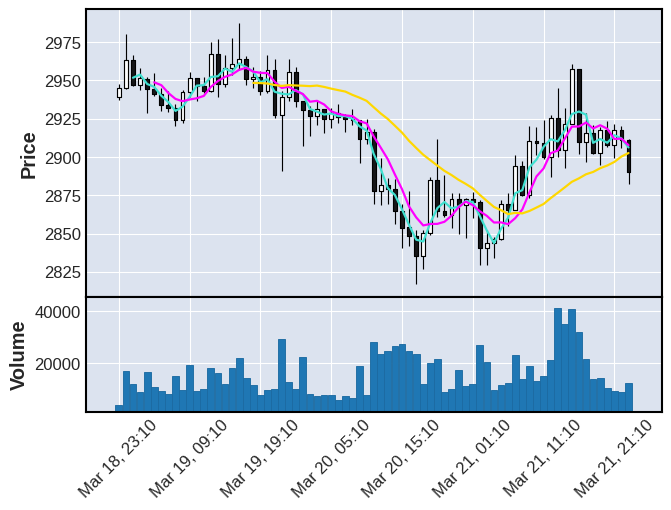

In [15]:
mpf.plot(ohlc_data, type="candle", mav=(3, 6, 20), volume=True)

Extend dataframe with TA indicators

In [16]:
_ = ohlc_data.ta.strategy(ta.AllStrategy, timed=True, verbose=True)
ohlc_data.head()

[+] Strategy: All
[i] Indicator arguments: {'timed': True, 'append': True}
[i] Excluded[12]: above, above_value, below, below_value, cross, cross_value, long_run, short_run, td_seq, tsignals, vp, xsignals
[i] Multiprocessing 131 indicators with 3 chunks and 24/24 cpus.


0it [00:00, ?it/s]/home/konrad/anaconda3/lib/python3.9/multiprocessing/pool.py:48: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return list(map(*args))
131it [00:00, 1048.46it/s]

[i] Total indicators: 131
[i] Columns added: 278
[i] Last Run: Thursday February 2, 2023, NYSE: 18:13:36, Local: 22:13:36 CET, Day 33/365 (9.00%)
[i] Runtime: 230.8529 ms (0.2309 s)


,open,high,low,close,weighted,volume,volume_asset,volume_asset_buyer_maker,volume_asset_buyer_taker,trades,...,VIDYA_14,VTXP_14,VTXM_14,VWAP_D,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-18 23:10:00,2938.84,2947.56,2937.28,2945.09,2942.565412,3633.4165,1.069157e+07,5.096296e+06,5.595270e+06,4747,...,NaN,NaN,NaN,2943.310000,NaN,2943.7550,NaN,NaN,NaN,NaN
2022-03-19 00:10:00,2945.09,2980.00,2944.61,2962.99,2965.139440,17107.4928,5.072610e+07,2.251947e+07,2.820663e+07,28322,...,NaN,NaN,NaN,2962.533333,NaN,2962.6475,NaN,NaN,NaN,NaN
2022-03-19 01:10:00,2962.99,2966.24,2946.16,2946.99,2958.016053,11745.3531,3.474294e+07,1.634730e+07,1.839564e+07,19958,...,NaN,NaN,NaN,2958.705445,NaN,2951.5950,NaN,NaN,NaN,NaN
2022-03-19 02:10:00,2947.00,2958.17,2944.00,2951.31,2950.926338,8636.7654,2.548646e+07,1.361999e+07,1.186647e+07,15796,...,NaN,NaN,NaN,2956.967144,NaN,2951.1975,NaN,NaN,NaN,NaN
2022-03-19 03:10:00,2951.16,2952.00,2928.55,2944.59,2942.006644,16477.7281,4.847759e+07,2.378533e+07,2.469226e+07,26741,...,NaN,NaN,NaN,2952.309732,NaN,2942.4325,NaN,NaN,NaN,NaN


In [17]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

Now let's connect all the elements: let's download and calculate technical indicators for a few selected currency pairs, selected date range and selected intervals.

In [18]:
START_DATE = date(2022, 4, 1)
END_DATE = date(2022, 4, 5)
PAIRS = ["ethusdt", "btcusdt"]
OHLC_INTERVALS = [10, 20]

ohlc_data = {
    pair: {
        interval: {
            OHLC_INTERVALS[0] * step: []
            for step in range(interval // OHLC_INTERVALS[0])
        }
        for interval in OHLC_INTERVALS
    }
    for pair in PAIRS
}

for pair in tqdm(PAIRS, desc="pairs loop"):
    for single_date in tqdm(
        [d for d in daterange(START_DATE, END_DATE)], desc="dates loop"
    ):
        print(pair, single_date.strftime("%Y-%m-%d"))
        try:
            day_trades = get_trades(
                pair,
                single_date.year,
                str(single_date.month).zfill(2),
                str(single_date.day).zfill(2),
            )
        except zipfile.BadZipfile:
            print("BadZipfile, probably wrong date")
            continue

        for interval in OHLC_INTERVALS:
            for step in range(interval // OHLC_INTERVALS[0]):
                offset = OHLC_INTERVALS[0] * step
                day_ohlc = trades2ohlc(
                    day_trades, resampling_frequency=interval, offset=offset
                )
                ohlc_data[pair][interval][offset].append(day_ohlc)

    makedirs(join(DATA_DIR, pair), exist_ok=True)
    for interval in OHLC_INTERVALS:
        for step in range(interval // OHLC_INTERVALS[0]):
            offset = OHLC_INTERVALS[0] * step
            ohlc_data[pair][interval][offset] = merge_ohlc(
                ohlc_data[pair][interval][offset]
            )
            ohlc_data[pair][interval][offset].ta.strategy(ta.AllStrategy)
            filename = f"ohlcvta_{pair}_{interval}_{offset}.csv"
            ohlc_data[pair][interval][offset].to_csv(join(DATA_DIR, pair, filename))

pairs loop:   0%|          | 0/2 [00:00<?, ?it/s]

dates loop:   0%|          | 0/4 [00:00<?, ?it/s]

ethusdt 2022-04-01
ethusdt 2022-04-02
ethusdt 2022-04-03
ethusdt 2022-04-04



0it [00:00, ?it/s]/home/konrad/anaconda3/lib/python3.9/multiprocessing/pool.py:48: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return list(map(*args))

131it [00:00, 639.77it/s]

0it [00:00, ?it/s]/home/konrad/anaconda3/lib/python3.9/multiprocessing/pool.py:48: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return list(map(*args))

131it [00:00, 757.63it/s]

0it [00:00, ?it/s]/home/konrad/anaconda3/lib/python3.9/multiprocessing/pool.py:48: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return list(map(*args))

131it [00:00, 827.67it/s][A


dates loop:   0%|          | 0/4 [00:00<?, ?it/s]

btcusdt 2022-04-01
btcusdt 2022-04-02
btcusdt 2022-04-03
btcusdt 2022-04-04



0it [00:00, ?it/s]/home/konrad/anaconda3/lib/python3.9/multiprocessing/pool.py:48: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return list(map(*args))

131it [00:00, 580.45it/s]

0it [00:00, ?it/s]/home/konrad/anaconda3/lib/python3.9/multiprocessing/pool.py:48: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return list(map(*args))

131it [00:00, 806.99it/s][A

0it [00:00, ?it/s]/home/konrad/anaconda3/lib/python3.9/multiprocessing/pool.py:48: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return list(map(*args))

131it [00:00, 783.74it/s]


This step involves a lot of data retrieval, IO operations, manipulation of unrelated structures. Taking advantage of the fact that dictionary update are thread-safe, we can easily convert this code to work in multiple threads, gaining a significant reduction in time.

In [19]:
def process_single_date(ohlc_data, pair, single_date, verbose=False):
    if verbose:
        print(pair, single_date.strftime("%Y-%m-%d"))
    try:
        day_trades = get_trades(
            pair,
            single_date.year,
            str(single_date.month).zfill(2),
            str(single_date.day).zfill(2),
        )
    except zipfile.BadZipfile:
        print("BadZipfile, probably wrong date")
        return None

    for interval in OHLC_INTERVALS:
        for step in range(interval // OHLC_INTERVALS[0]):
            offset = OHLC_INTERVALS[0] * step
            day_ohlc = trades2ohlc(
                day_trades, resampling_frequency=interval, offset=offset
            )
            ohlc_data[pair][interval][offset][single_date] = day_ohlc


def save_ohlc_ta(ohlc_data, pair, interval, offset):
    ohlc_data[pair][interval][offset] = merge_ohlc(ohlc_data[pair][interval][offset])
    ohlc_data[pair][interval][offset].ta.strategy(ta.AllStrategy)
    filename = f"ohlcvta_{pair}_{interval}_{offset}.csv"
    ohlc_data[pair][interval][offset].to_csv(join(DATA_DIR, pair, filename))

In [20]:
def download_single_thread():
    ohlc_data = {
        pair: {
            interval: {
                OHLC_INTERVALS[0] * step: {}
                for step in range(interval // OHLC_INTERVALS[0])
            }
            for interval in OHLC_INTERVALS
        }
        for pair in PAIRS
    }

    pair_date = [
        (pair, single_date)
        for pair in PAIRS
        for single_date in daterange(START_DATE, END_DATE)
    ]

    for pad in pair_date:
        process_single_date(ohlc_data, *pad)

    for pair in PAIRS:
        makedirs(join(DATA_DIR, pair), exist_ok=True)
    params_list = [
        (pair, interval, OHLC_INTERVALS[0] * step)
        for pair in PAIRS
        for interval in OHLC_INTERVALS
        for step in range(interval // OHLC_INTERVALS[0])
    ]
    for params in params_list:
        save_ohlc_ta(ohlc_data, *params)


def download_multi_thread(n_threads=20):
    ohlc_data = {
        pair: {
            interval: {
                OHLC_INTERVALS[0] * step: {}
                for step in range(interval // OHLC_INTERVALS[0])
            }
            for interval in OHLC_INTERVALS
        }
        for pair in PAIRS
    }

    pair_date = [
        (pair, single_date)
        for pair in PAIRS
        for single_date in daterange(START_DATE, END_DATE)
    ]
    # start the thread pool
    with ThreadPoolExecutor(n_threads) as executor:
        futures = [
            executor.submit(process_single_date, ohlc_data, *data) for data in pair_date
        ]
        # wait for all tasks to complete
        wait(futures, return_when=ALL_COMPLETED)

    for pair in PAIRS:
        makedirs(join(DATA_DIR, pair), exist_ok=True)
    params_list = [
        (pair, interval, OHLC_INTERVALS[0] * step)
        for pair in PAIRS
        for interval in OHLC_INTERVALS
        for step in range(interval // OHLC_INTERVALS[0])
    ]
    with ThreadPoolExecutor(n_threads) as executor:
        futures = [
            executor.submit(save_ohlc_ta, ohlc_data, *params) for params in params_list
        ]
        wait(futures, return_when=ALL_COMPLETED)

In [ ]:
START_DATE = date(2022, 4, 1)
END_DATE = date(2022, 4, 11)
PAIRS = ["ethusdt", "btcusdt", "bnbusdt"]
OHLC_INTERVALS = [10, 20]

start = monotonic()
download_single_thread()
single_thread_time = monotonic() - start

start = monotonic()
download_multi_thread()
multi_thread_time = monotonic() - start

In [22]:
print(f"single thread time: {single_thread_time}")
print(f"multi thread time: {multi_thread_time}")

single thread time: 147.51526107399695
multi thread time: 27.73965536399919


We will now save a bit more data for further analysis

In [ ]:
START_DATE = date(2022, 4, 1)
END_DATE = date(2022, 4, 30)
PAIRS = ["ethusdt", "btcusdt", "bnbusdt", "dogeusdt", "ftmusdt", "ancusdt", "cakebusd"]
OHLC_INTERVALS = [20, 60, 120]

start = monotonic()
download_multi_thread()
multi_thread_time = monotonic() - start

In [24]:
print(f"multi thread time: {multi_thread_time}")

multi thread time: 148.0312844939981
